# Architecture Design Neural Network

# Data

As our dataset we will use the WORLD-OWID-Features dataset, which I extracted from the normal WORLD-OWID dataset. 

you can see the feature engineering in the following notebook. 
sharable link: http://localhost:8888/lab/tree/Feature%20engineering.ipynb 

After this we turned our yearly dataset into montly data set by interpolating:
http://localhost:8888/files/Yearly_to_Monthly_Data.ipynb 

In [79]:
import pandas as pd
import numpy as np
#import numpy as np
import tensorflow as tf 
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import callbacks
from keras.callbacks import EarlyStopping

In [84]:
df = pd.read_csv('DataSets /WORLD-OWID-features-Monthly')


df['year'] = pd.to_datetime(df['year'], format='%Y-%m-%d')
df.set_index('year', inplace=True)

#start_year = pd.to_datetime('1880-01-01')


#df = df[start_year:]

df

,cement_co2,co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,other_industry_co2
year,,,,,,,,
1880-01-01,0.00000,853.705000,838.340000,256.309556,1814.698707,3100.721000,15.364000,82.069576
1880-02-01,0.00000,856.096667,840.575167,256.309556,1814.698707,3100.405500,15.520500,82.069576
1880-03-01,0.00000,858.488333,842.810333,256.309556,1814.698707,3100.090000,15.677000,82.069576
1880-04-01,0.00000,860.880000,845.045500,256.309556,1814.698707,3099.774500,15.833500,82.069576
1880-05-01,0.00000,863.271667,847.280667,256.309556,1814.698707,3099.459000,15.990000,82.069576
...,...,...,...,...,...,...,...,...
2020-09-01,1660.90700,36503.930000,14711.253333,413.545333,7799.983333,3978.615333,11622.042333,296.198000
2020-10-01,1663.82825,36658.910500,14778.339500,414.290500,7830.445000,3968.722500,11675.821500,296.185000
2020-11-01,1666.74950,36813.891000,14845.425667,415.035667,7860.906667,3958.829667,11729.600667,296.172000


# Doing some possible small manually feature analysis based upon other projects 

In [3]:
#features_to_keep = ['year', 'co2', 'population', 'gdp', 'cement_co2', 'primary_energy_consumption', 'share_global_cumulative_gas_co2', 'share_global_cumulative_coal_co2', 'share_global_cumulative_flaring_co2', 'share_global_cumulative_oil_co2']

# df = df[features_to_keep]

#This is from the old dataset !!

# Visualizing our X features (industries) againt our y (total-all-sectors) feature

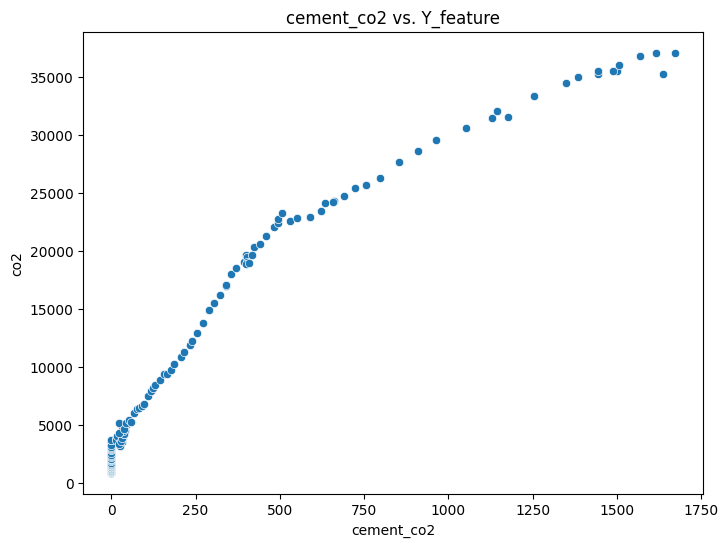

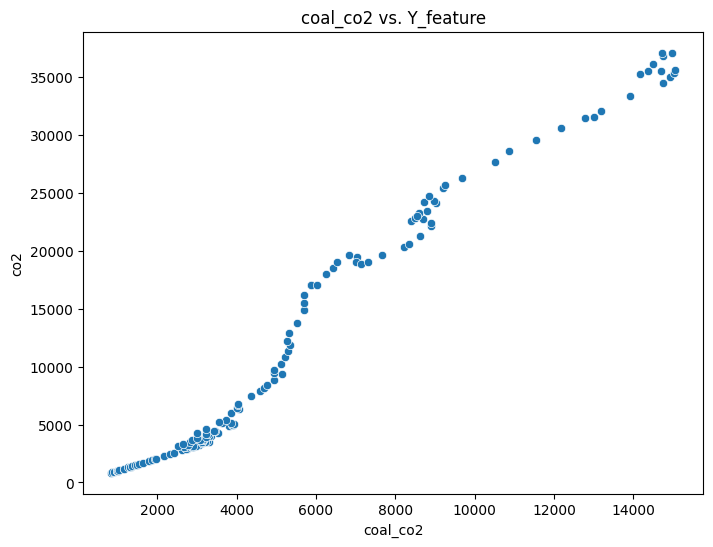

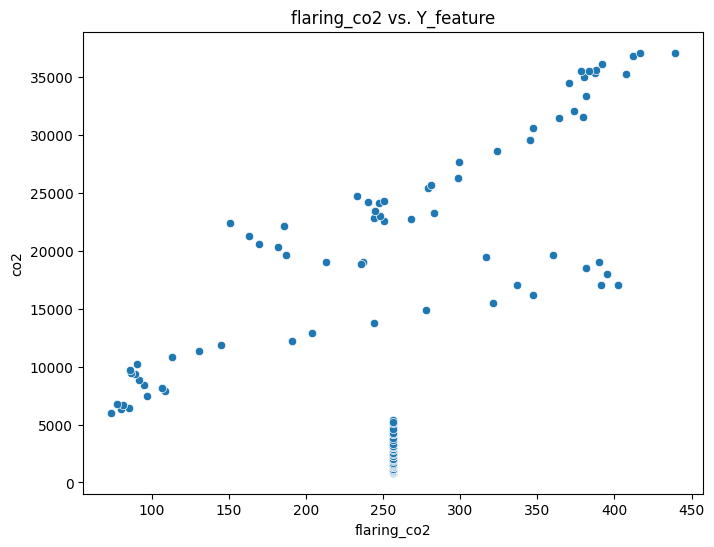

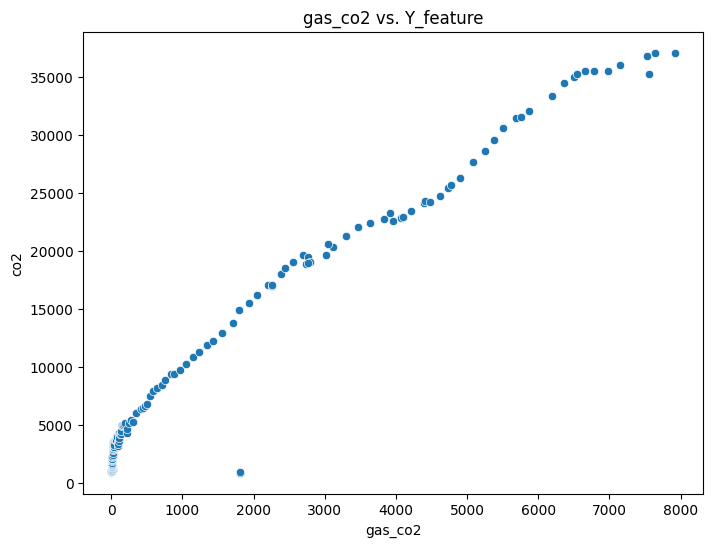

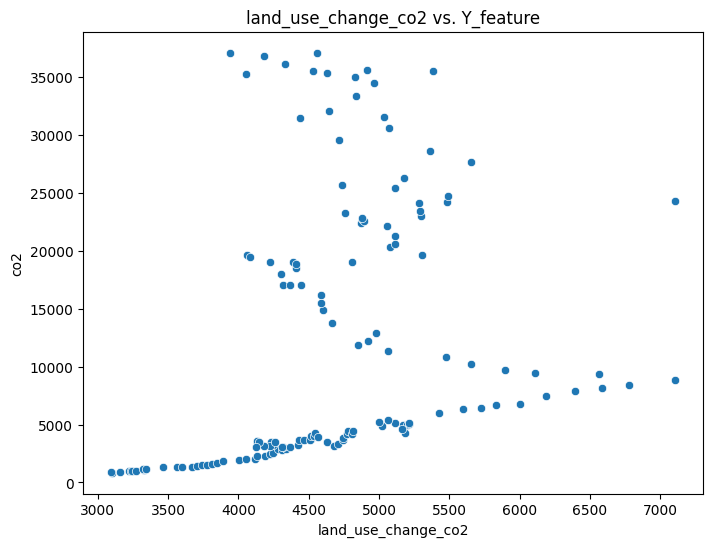

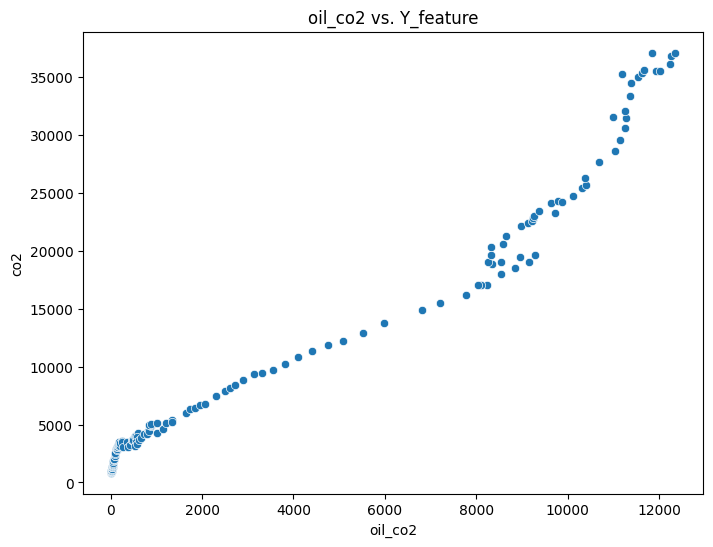

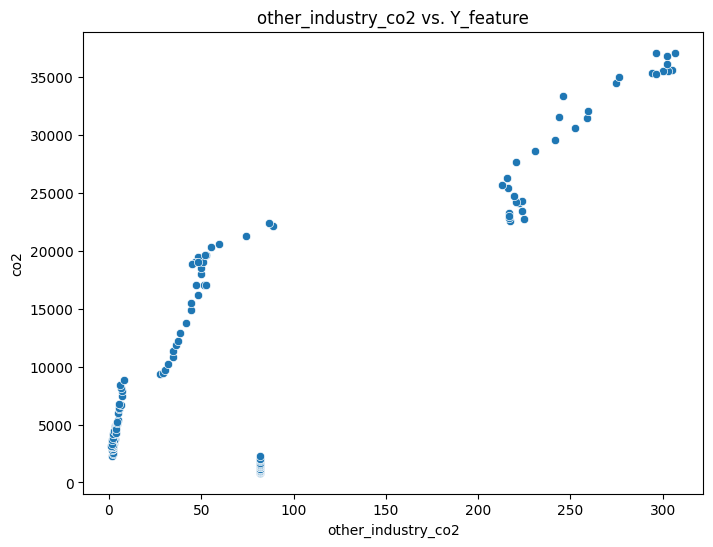

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Voorbeeld: stel 'data' is je dataset in een pandas DataFrame,
# en 'Y_feature' is de naam van je Y-feature (target variable).

# Creëer scatterplots voor elke X-feature tegenover Y-feature
for column in df.columns:
    if column != 'co2':  # Zorg ervoor dat je de Y-feature niet tegenover zichzelf plaatst
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=column, y='co2', data=df)
        plt.title(f'{column} vs. Y_feature')
        plt.xlabel(column)
        plt.ylabel('co2')
        plt.show()

# Defining our X and Y 

In [85]:
#df.set_index('year', inplace=True)
X = df.drop('co2', axis=1)
y = df['co2']


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1693 entries, 1880-01-01 to 2021-01-01
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cement_co2           1693 non-null   float64
 1   co2                  1693 non-null   float64
 2   coal_co2             1693 non-null   float64
 3   flaring_co2          1693 non-null   float64
 4   gas_co2              1693 non-null   float64
 5   land_use_change_co2  1693 non-null   float64
 6   oil_co2              1693 non-null   float64
 7   other_industry_co2   1693 non-null   float64
dtypes: float64(8)
memory usage: 119.0 KB


# Splitting our Data 

In [87]:
'''# Bereken het indexpunt waar de splitsing moet plaatsvinden
split_index = int(len(df) * 0.9)

# Split de gegevens in trainingsset en testset op basis van de index
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]'''

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(1693, 7)
(339, 7)
(1354,)
(339,)


In [50]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Detecting and Deleting Outliers 

# Structuring our Model 

In order to find the best possible parameters for our network we will use **gridsearch** to do this for us

In [8]:
'''from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
}'''

"from sklearn.model_selection import GridSearchCV\nfrom sklearn.neural_network import MLPRegressor\n\nparam_grid = {\n    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],\n    'activation': ['relu', 'tanh'],\n    'alpha': [0.0001, 0.001, 0.01],\n}"

In [9]:
#model = MLPRegressor(max_iter=500, random_state=42)

In [10]:
#grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
#grid_search.fit(X_train, y_train)

In [11]:
#best_model = grid_search.best_estimator_
#best_params = grid_search.best_params_

In [12]:
#y_pred = best_model.predict(X_test)
#mse = mean_squared_error(y_test, y_pred)

# Huber Loss

In [13]:
# Since for the dataset we are using now we have outliers, we could potentially use the Huber Loss, which is not sensitive to outliers 

def huber_loss(delta):
    def loss(y_true, y_pred):
        error = y_true - y_pred
        huber_condition = tf.abs(error) < delta
        squared_loss = 0.5 * tf.square(error)
        linear_loss = delta * (tf.abs(error) - 0.5 * delta)
        return tf.where(huber_condition, squared_loss, linear_loss)
    return loss

delta = 1.0

# Optuna optimatization 

In [88]:
def create_ann_model(input_dim, optimizer, learning_rate, activation, num_layers, num_units, dropout_rate):
    model = Sequential()
    model.add(Dense(num_units, activation=activation, input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(num_units, activation=activation))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))  # Depending on your problem, e.g., regression or classification
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model

In [89]:
def objective(trial):
    # Define search spaces for hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    n_epochs = trial.suggest_int('n_epochs', 25, 50)
    activation = trial.suggest_categorical('activation', ['relu', 'linear', 'leaky_relu'])
    num_layers = trial.suggest_int('num_layers', 4, 12)
    num_units = trial.suggest_int('num_units', 64, 256)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.35)
    
    if activation == 'leaky_relu':
        activation_fn = LeakyReLU(alpha=0.2)
    else:
        activation_fn = activation
    
    if optimizer_name == 'adam':
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=learning_rate)
    
    # Create the model with current trial parameters
    model = create_ann_model(input_dim=(X_train.shape[1]), optimizer=optimizer, learning_rate=learning_rate,
                             activation=activation_fn, num_layers=num_layers, num_units=num_units, dropout_rate=dropout_rate)

    model.compile(loss="mean_absolute_error", optimizer="adam")
    
    # Train the model
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.15, verbose=1)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate mean absolute error as evaluation metric
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

In [90]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)  

[I 2023-08-16 16:10:58,962] A new study created in memory with name: no-name-292fc138-2d75-4280-b6ab-6d1fe69bb052
/var/folders/3d/ww3w94xd4y9bsnytmzvvs9340000gn/T/ipykernel_11583/526353527.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)


Epoch 1/35
18/18 [==============================] - 1s 11ms/step - loss: 12099.5098 - val_loss: 12385.6982
Epoch 2/35
18/18 [==============================] - 0s 5ms/step - loss: 12099.1309 - val_loss: 12381.3262
Epoch 3/35
18/18 [==============================] - 0s 5ms/step - loss: 12098.8779 - val_loss: 12379.7744
Epoch 4/35
18/18 [==============================] - 0s 5ms/step - loss: 12098.4248 - val_loss: 12378.7627
Epoch 5/35
18/18 [==============================] - 0s 5ms/step - loss: 12097.8369 - val_loss: 12377.5850
Epoch 6/35
18/18 [==============================] - 0s 6ms/step - loss: 12097.1631 - val_loss: 12376.2725
Epoch 7/35
18/18 [==============================] - 0s 6ms/step - loss: 12096.1953 - val_loss: 12375.9043
Epoch 8/35
18/18 [==============================] - 0s 6ms/step - loss: 12095.0918 - val_loss: 12372.2900
Epoch 9/35
18/18 [==============================] - 0s 6ms/step - loss: 12093.7109 - val_loss: 12371.5537
Epoch 10/35
18/18 [==========================

[I 2023-08-16 16:11:03,914] Trial 0 finished with value: 11592.533859163688 and parameters: {'learning_rate': 0.008896156982515382, 'batch_size': 64, 'n_epochs': 35, 'activation': 'linear', 'num_layers': 11, 'num_units': 165, 'optimizer': 'adam', 'dropout_rate': 0.3022596926801925}. Best is trial 0 with value: 11592.533859163688.


Epoch 1/37


/var/folders/3d/ww3w94xd4y9bsnytmzvvs9340000gn/T/ipykernel_11583/526353527.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)


36/36 [==============================] - 1s 4ms/step - loss: 12099.3242 - val_loss: 12380.8750
Epoch 2/37
36/36 [==============================] - 0s 2ms/step - loss: 12098.6836 - val_loss: 12378.8379
Epoch 3/37
36/36 [==============================] - 0s 2ms/step - loss: 12097.7227 - val_loss: 12378.6260
Epoch 4/37
36/36 [==============================] - 0s 3ms/step - loss: 12096.1748 - val_loss: 12376.3555
Epoch 5/37
36/36 [==============================] - 0s 3ms/step - loss: 12093.8848 - val_loss: 12370.9551
Epoch 6/37
36/36 [==============================] - 0s 3ms/step - loss: 12090.7529 - val_loss: 12367.1309
Epoch 7/37
36/36 [==============================] - 0s 3ms/step - loss: 12086.7217 - val_loss: 12362.6074
Epoch 8/37
36/36 [==============================] - 0s 3ms/step - loss: 12081.6406 - val_loss: 12360.3164
Epoch 9/37
36/36 [==============================] - 0s 2ms/step - loss: 12075.5938 - val_loss: 12352.5537
Epoch 10/37
36/36 [==============================] - 0s 3

[I 2023-08-16 16:11:07,931] Trial 1 finished with value: 11206.809998752171 and parameters: {'learning_rate': 0.0014589581308858983, 'batch_size': 32, 'n_epochs': 37, 'activation': 'leaky_relu', 'num_layers': 6, 'num_units': 131, 'optimizer': 'adam', 'dropout_rate': 0.18257072277050646}. Best is trial 1 with value: 11206.809998752171.


Epoch 1/49


/var/folders/3d/ww3w94xd4y9bsnytmzvvs9340000gn/T/ipykernel_11583/526353527.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)


18/18 [==============================] - 1s 12ms/step - loss: 12099.4834 - val_loss: 12345.6553
Epoch 2/49
18/18 [==============================] - 0s 6ms/step - loss: 12099.0420 - val_loss: 12361.6436
Epoch 3/49
18/18 [==============================] - 0s 6ms/step - loss: 12098.6240 - val_loss: 12368.0527
Epoch 4/49
18/18 [==============================] - 0s 6ms/step - loss: 12098.0303 - val_loss: 12368.3096
Epoch 5/49
18/18 [==============================] - 0s 6ms/step - loss: 12097.2656 - val_loss: 12378.3330
Epoch 6/49
18/18 [==============================] - 0s 8ms/step - loss: 12096.2432 - val_loss: 12386.0566
Epoch 7/49
18/18 [==============================] - 0s 8ms/step - loss: 12094.8516 - val_loss: 12394.7637
Epoch 8/49
18/18 [==============================] - 0s 8ms/step - loss: 12093.1621 - val_loss: 12381.6387
Epoch 9/49
18/18 [==============================] - 0s 9ms/step - loss: 12091.1436 - val_loss: 12379.4893
Epoch 10/49
18/18 [==============================] - 0s 

[W 2023-08-16 16:11:11,796] Trial 2 failed with parameters: {'learning_rate': 0.001544225582572166, 'batch_size': 64, 'n_epochs': 49, 'activation': 'linear', 'num_layers': 12, 'num_units': 229, 'optimizer': 'adam', 'dropout_rate': 0.24108952887547394} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/wout_vp/venv-metal/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/3d/ww3w94xd4y9bsnytmzvvs9340000gn/T/ipykernel_11583/526353527.py", line 29, in objective
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.15, verbose=1)
  File "/Users/wout_vp/venv-metal/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/Users/wout_vp/venv-metal/lib/python3.11/site-packages/keras/src/

KeyboardInterrupt: 

In [76]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 7))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150
3/3 [==============================] - 0s 26ms/step - loss: -439.8547 - accuracy: 0.0000e+00 - val_loss: -635.6719 - val_accuracy: 0.0000e+00
Epoch 2/150
3/3 [==============================] - 0s 5ms/step - loss: -558.1380 - accuracy: 0.0000e+00 - val_loss: -738.3162 - val_accuracy: 0.0000e+00
Epoch 3/150
3/3 [==============================] - 0s 5ms/step - loss: -475.2437 - accuracy: 0.0000e+00 - val_loss: -859.8414 - val_accuracy: 0.0000e+00
Epoch 4/150
3/3 [==============================] - 0s 5ms/step - loss: -578.1367 - accuracy: 0.0000e+00 - val_loss: -1000.2449 - val_accuracy: 0.0000e+00
Epoch 5/150
3/3 [==============================] - 0s 5ms/step - loss: -842.5693 - accuracy: 0.0000e+00 - val_loss: -1158.1783 - val_accuracy: 0.0000e+00
Epoch 6/150
3/3 [==============================] - 0s 5ms/step - loss: -904.3988 - accuracy: 0.0000e+00 - val_loss: -1330.0026 - val_accuracy: 0.0000e+00
Epoch 7/150
3/3 [==============================] - 0s 4ms/step - loss: -1077.0

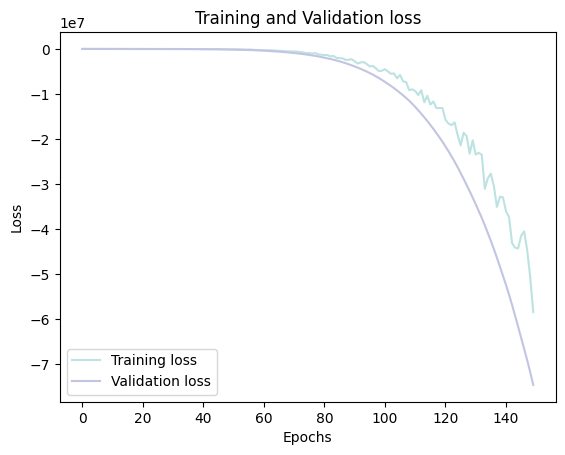

In [77]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

In [ ]:
print('Best trial:')
trial = study.best_trial
print(f'  Mean Absolute Error: {trial.value:.4f}')
print('  Hyperparameters:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

np.random.seed(seed)
tf.random.set_seed(seed)

# Get the best hyperparameters from the best trial
best_params = study.best_params

# Create the best model using the best hyperparameters
best_model = create_ann_model(input_dim=X_train.shape[1],
                              optimizer=best_params['optimizer'],
                              learning_rate=best_params['learning_rate'],
                              activation=best_params['activation'],
                              num_layers=best_params['num_layers'],
                              num_units=best_params['num_units'])
                              

# Train the best model on the entire training set
best_model.fit(X_train, y_train, epochs=best_params['n_epochs'], batch_size=best_params['batch_size'], validation_split=0.2, verbose=1)

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n")
print(f'R2 Score: {r2:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')

# Plot predictions vs. test values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'Predicted vs. True Values (R2={r2:.4f}, MAE={mae:.4f}, RMSE={rmse:.4f})')
plt.show()

plt.plot(y_test.values, label='True CO2 Emissions')
plt.plot(y_pred, label='Predicted CO2 Emissions')
plt.xlabel('Data Points')
plt.ylabel('CO2 Emissions')
plt.title('True vs. Predicted CO2 Emissions')
plt.legend()
plt.show()

# Manually testing to get a rough overview 

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

# Hyperparameters 

batch_size = 64 
epochs = 100
learning_rate = 0.001 
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ReLU, Dropout

input_size = X_train.shape[1]

model = Sequential()

model.add(Dense(128, activation='leaky_relu', input_dim=input_size))
model.add(Dropout(0.2))  # Adding dropout regularization with 20% dropout rate

model.add(Dense(64, activation='leaky_relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='leaky_relu'))
model.add(Dropout(0.2))  

model.add(Dense(32, activation='leaky_relu'))
model.add(Dropout(0.2))  

model.add(Dense(1, activation='linear'))

In [ ]:
model.summary()

Compiling our model

In [ ]:
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

# Training our model with cross validation

In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Model Evaluation 

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score

R2 = r2_score(y_test, y_pred)
print("R2 Score=",R2 )

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Mean Squared Error (MSE) =", rmse)

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, y_pred)
print("(MAPE)) =", mape)

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute error (MAE) =", mae)

# Visualizing which feature contributed the most to CO2 

In [ ]:
# Getting our updated weights of our final layer 
output_layer_weights = model.layers[-1].get_weights()[0]

# Calculating the absolute weights 
absolute_weights = abs(output_layer_weights)

# Putting them together in a list with their names 
feature_names = list(X.columns)

# We will make a dictionary to connect our feature names with their corresponding absolute weight input against co2
feature_weights_dict = dict(zip(feature_names, absolute_weights))

# Sorting from best to worst 
sorted_feature_weights = sorted(feature_weights_dict.items(), key=lambda x: x[1], reverse=True)

for feature, weight in sorted_feature_weights:
    print(f"Feature: {feature}, Absolute Weight: {weight}")

# Visualizing the outcoms 

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('True CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('True vs. Predicted CO2 Emissions for Training Data')
plt.show()

In [ ]:
# Access the Mean Absolute Errors from the training and validation data
train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']

# Get the number of epochs
epochs = range(1, len(train_mae) + 1)

# Plot the MAEs against each other
plt.plot(epochs, train_mae, label='Training MAE')
plt.plot(epochs, val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

In [ ]:
# Plot the true values and predicted values as separate lines
plt.plot(y_test.values, label='True CO2 Emissions')
plt.plot(y_pred, label='Predicted CO2 Emissions')
plt.xlabel('Data Points')
plt.ylabel('CO2 Emissions')
plt.title('True vs. Predicted CO2 Emissions')
plt.legend()
plt.show()

# Tracking our error/accuracy metrics 

In [ ]:
y_pred.shape


In [ ]:
y_test.shape

In [ ]:
'''import matplotlib.pyplot as plt

# Assuming you have already predicted the CO2 emissions and stored them in y_pred

# Inverse transform y_pred and y_test to bring them back to their original scale
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# Reset the index of the DataFrame to ensure alignment with y_pred_original and y_test_original
df_reset_index = df.reset_index(drop=True)

# Create a new DataFrame to hold the last 30% of the years and corresponding y_pred and y_test
last_30_percent = int(len(df) * 0.3+1)
result_df = pd.DataFrame({
    'Year': df['year'].iloc[-last_30_percent:],
    'Actual CO2 Emissions': y_test_original.flatten(),
    'Predicted CO2 Emissions': y_pred_original.flatten()
})

# Sort the DataFrame by the year
result_df = result_df.sort_values(by='Year')

# Plot the relationship between predicted and actual CO2 emissions over the years
plt.plot(result_df['Year'], result_df['Actual CO2 Emissions'], label='Actual CO2 Emissions')
plt.plot(result_df['Year'], result_df['Predicted CO2 Emissions'], label='Predicted CO2 Emissions')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.title('Actual vs. Predicted CO2 Emissions over the Years')
plt.show()'''

In [ ]:
import matplotlib.pyplot as plt

# Plot the relationship between "year" and "CO2 emissions"
plt.scatter(df["year"], df["co2"])
plt.xlabel("Year")
plt.ylabel("CO2 Emissions")
plt.title("CO2 Emissions over Time")
plt.show()

In [ ]:
'''from tensorflow.keras.callbacks import Callback

class CustomMSECallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        mse = logs['val_loss']  # Validation loss corresponds to MSE
        print(f"Epoch {epoch+1}: Average MSE = {mse:.4f}")

# Define the input size, hidden size, and output size
input_size = len(X_train.columns)  # Replace this with the actual number of input features
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 1   # Number of output units (in this case, predicting CO2 emissions as a continuous value)

# Create the neural network model
model = Sequential([
    Dense(hidden_size, input_shape=(input_size,), activation='relu'),
    Dense(output_size)
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Create the custom callback
custom_callback = CustomMSECallback()

# Train the model with the custom callback
num_epochs = 100
batch_size = 64
history = model.fit(X_train.values, y_train.values, epochs=num_epochs, batch_size=batch_size, validation_split=0.2, callbacks=[custom_callback])

# Evaluate the model on the test data
test_loss = model.evaluate(X_test.values, y_test.values)
print(f"Average Test Loss: {test_loss:.4f}")'''